# CS304 Project 6
In this project, we are required to train digit HMMs from continuous speech recordings and recognize continuous digit sequences.

Packages import

In [18]:
import CDR
import os
from num2words import num2words
import sentence as st
import numpy as np
import DTW
from time import time

## Part 1 Training
Author: Tianle Zhu

For complete code of training part, please refer to ***train_st.py***.

The first part of this project is to train HMM models from continuous speech recordings. 

Our training data is **30** continuous speech recordings of the sequences below stored under ***./sequences***. 
* *0 1 2 3 4 5 6 7 8 9* 
* *9 8 7 6 5 4 3 2 1 0* 
* *1 2 3 4 5 6 7 8 9 0* 
* *0 9 8 7 6 5 4 3 2 1* 
* *1 3 5 7 9 0 2 4 6 8* 
* *8 6 4 2 0 9 7 5 3 1*
  
Each sequence has five recordings and all of them are recorded by one person. 

The whole process of training can be described by t he following steps:
1. Initialize model from isolated digit models
2. Read in recordings. For each recording, build a graph using loaded HMMs according to the digit sequence.
3. Perform DTW to align the mfcc vectors of each recording to their corresponding graph. 
4. Update HMM models after all 30 recordings are used. 
5. If the model does not converge, goes back to step 2

We will demonstrate our code for each step. 

### Step 1 Model Initialization
The following block defines the function to load isolated digit HMMs, which are stored under ***./model/tz***. 

In [10]:
def initialize_model(sequence_folder):
    """
    load pre-trained HMMs of isolated digits. Return the HMMs in a list. 
    """
    # read pre-trained isolated digit models
    obj_ls = []
    for i in range(10):
        obj = CDR.Hmm(num2words(i), "")
        obj_ls.append(obj)
    # read pre-trained silence model
    obj_ls.append(CDR.Hmm("sil", "sil0"))
    obj_ls.append(CDR.Hmm("sil", "sil1"))
    return obj_ls

### Step 2 Read Recordings & Graph Building
The following block defines the function to read all recording as *Sentence* objects and return them in a list. 

For the *Sentence* object, please refer to ***sentence.py***. 

In [11]:
def get_recordings(folderpath):
    """read and return all recordings under folderpath

    :param folderpath: path of recording folder
    :return: list of sentence object
    """
    sentence_ls = []
    for file in os.listdir(folderpath):
        filename = os.path.join(folderpath, file)
        sentence = st.Sentence(filename)
        sentence_ls.append(sentence)
    return sentence_ls

The following block defines the functions to connect HMMs based on digit sequence. 

Functions **resetHead()** and **resetTail()** are used to remove non-emitting states of the last alignment.

In [12]:

def resetHead(hmm):
    """
    remove null state of last alignment from edges of head state of given hmm
    """
    head = hmm.getHead()
    new_edge = []
    for edge in head.edges:
        parentNode = edge[0]
        # ignore all non-emitting parents
        if not parentNode.isNull:
            new_edge.append(edge)
    head.edges = new_edge


def resetTail(hmm):
    """
    remove null state of last alignment from children of tail state of given hmm
    """
    tail = hmm.getTail()
    tail.next = []


def connect(nullstate, hmm):
    """
    first remove all null state from last alignment,
    then connect hmm after give null state and connect a new null state after the hmm, return the new null state

    :param nullstate: given nullstate
    :param hmm: given hmm
    :return: new initizlied nullstate
    """
    # remove all non-emitting states from last alignment
    resetHead(hmm)
    resetTail(hmm)
    # connect head state
    nullstate.next.append(hmm.getHead())
    hmm.getHead().edges.append((nullstate, 1.0))
    # initialize and connect new non-emitting state
    new_null = CDR.NullState()
    hmm.getTail().next.append(new_null)
    new_null.edges.append((hmm.getTail(), 0.5))
    return new_null


def get_node_ls(sentence, obj_ls):
    """build graph according to given sentence and return the flattened graph

    :param sentence: given sentence object
    :param obj_ls: already initialized hmm models
    :return: flattened graph (node list)
    """
    sentencePath = sentence.name  # get recording path
    # get digit sequence (string)
    _, tail = os.path.split(sentencePath)
    digit_seq = tail.split(".")[0].split("_")[0]
    # initialize starting non-emitting state
    startNull = CDR.NullState()
    # get first silence hmm
    sil_0 = obj_ls[-1]
    # connect starting non-emitting and first silence, get second non-emitting state
    currNull = connect(startNull, sil_0)
    # conncect all digit hmms
    for digit in digit_seq:
        hmm = obj_ls[int(digit)]
        currNull = connect(currNull, hmm)
    # connect end silence
    sil_1 = obj_ls[-2]
    currNull = connect(currNull, sil_1)
    return CDR.flatten(startNull)

### Step 3 Alignment/DTW

This is what we have implemented in previous projects. 

For the complete code of DTW and back pointer table implementation, please refer to ***DTW.py***

### Step 4 Update HMMs

Our strategy for updating is to assign each mfcc vector to their corresponding state by the results of DTW.

In real implementation, we defines a list *feature_ls* to store vectors by state id. 

The following block defines the functions to assign vectors using DTW results and update models after all 30 recordings are aligned. 

In [13]:
def assign_vectors(sentence, path, feature_ls):
    """assign each vector in the sentece to corresponding state (by result of alignment)

    :param sentence: setence object
    :param path: path (result of alignment)
    :param feature_ls: basket list that holds all vectors
    """
    for t in range(len(sentence.val)):
        vector = sentence.val[t]
        id = path[t].id
        # store vector based on state id
        vector_arr = feature_ls[id]
        # vstack all vectors
        vector_arr = np.vstack((vector_arr, vector))
        feature_ls[id] = vector_arr


def update(node_ls, feature_ls):
    """update mean, cov, transition probabilities of all emitting states

    :param node_ls: node list
    :param feature_ls: basket list that holds all vectors
    """
    for node in node_ls:
        # skip null state
        if node.isNull:
            continue
        # get all features belong to this state by state id
        vector_arr = feature_ls[node.id]
        vectorNum = len(vector_arr)
        sentenceNum = 30
        # calculate self transition probability
        self_trans_prob = (vectorNum - sentenceNum) / vectorNum
        self_trans_prob = np.where(self_trans_prob == 0, np.finfo(np.float64).eps, self_trans_prob)
        # calculate mean
        mean = np.mean(vector_arr, 0)
        # calculate covariance matrix (diagonal)
        cov_mat = np.cov(vector_arr.T)
        cov_diag = np.diag(cov_mat)
        # update transition probabilities
        new_edges = []
        for edge in node.edges:
            parentNode = edge[0]
            # update self transition probability
            if parentNode == node:
                new_edges.append((parentNode, self_trans_prob))
            # update parent transition probability
            else:
                if parentNode.isNull:
                    new_edges.append((parentNode, 1))
                else:
                    new_edges.append((parentNode, next_trans_prob))
        # calculate parent transition probability for child
        next_trans_prob = 1 - self_trans_prob

        node.edges = new_edges
        # update mean
        node.mean = mean
        # update covariance
        node.cov = cov_diag

### Step 5 Check Convergence
This step is trivial and also what we have implemented before. You can also refer to it in ***DTW.py***

### Then we can train the model from continuous recording using function *train()*. 

In ***train_st.py***, we store the trained models for each digit including silence under **./model/tz_trained**. However, since here we also want to examine convergence, the models will not be stored. 

In [23]:
def train(verbose, threshold, iterNum=None):
    """
    training digit hmm models from continuous digit sequences
    """
    sequence_folder = "./sequences/tz"
    obj_ls = initialize_model(sequence_folder)
    converge = False
    iteration = 0
    prev_cost = None
    sentence_ls = get_recordings(sequence_folder)
    cost_ls = []
    while not converge:
        if verbose:
            print("iteration: ", iteration)
        total_cost = 0
        feature_ls = [np.empty((0, 39)) for i in range(73)]  # basket list holds all vectors by state id they belong to
        for sentence in sentence_ls:  # align all sentence in one iteration
            node_ls, nodeNum = get_node_ls(sentence, obj_ls)  # get node list (flattened graph)
            cost, bpt = DTW.DTW(sentence.val, node_ls)  # DTW, alignment
            # print(bpt)
            total_cost += cost
            _, path = DTW.parseBPT(bpt)  # parse back pointer table to get path
            segment = sentence.update_segment(path)
            assign_vectors(sentence, path, feature_ls)  # assign each vector to corresponding state
            """ if verbose:
                # utils.print_seq(path)
                print(segment)
                print("*" * 100) """
        if verbose:
            print("total cost: ", total_cost)
        update(node_ls, feature_ls)  # update all nodes after all alignments complete
        if iteration != 0:
            converge = DTW.check_convergence(prev_cost, total_cost, threshold)
        
        # specify iteration to show convergence
        if iterNum != None and iteration < iterNum - 1:
            converge = False
        elif iterNum != None and iteration == iterNum - 1:
            converge = True
        
        iteration += 1
        prev_cost = total_cost
        cost_ls.append(total_cost)
    return cost_ls

Training using convergence threshold 0.01

In [33]:
start = time()
cost_1 = train(True, 0.01)
end = time()
print("total wall time: {:.4f} seconds".format(end - start))

iteration:  0
total cost:  257018.014889182
iteration:  1
total cost:  204203.56511388652
iteration:  2
total cost:  197517.74970518154
iteration:  3
total cost:  200763.9475711022
iteration:  4
total cost:  202719.95622365124
total wall time: 78.9878 seconds


The model converge after 5 iterations, using a total wall time about 82 seconds. 

We can also specify the iteration number to further examine the convergence. 

Train the model for 10 iterations. 

In [34]:
start = time()
cost_2 = train(True, 0.01, 10)
end = time()
print("total wall time: {:.4f}".format(end - start))

iteration:  0
total cost:  257018.014889182
iteration:  1
total cost:  204203.56511388652
iteration:  2
total cost:  197517.74970518154
iteration:  3
total cost:  200763.9475711022
iteration:  4
total cost:  202719.95622365124
iteration:  5
total cost:  204492.59580832638
iteration:  6
total cost:  204658.83653246894
iteration:  7
total cost:  205398.9185084263
iteration:  8
total cost:  206258.52356579338
iteration:  9
total cost:  204232.5570693745
total wall time: 156.8741


Show the cost of each iteration.

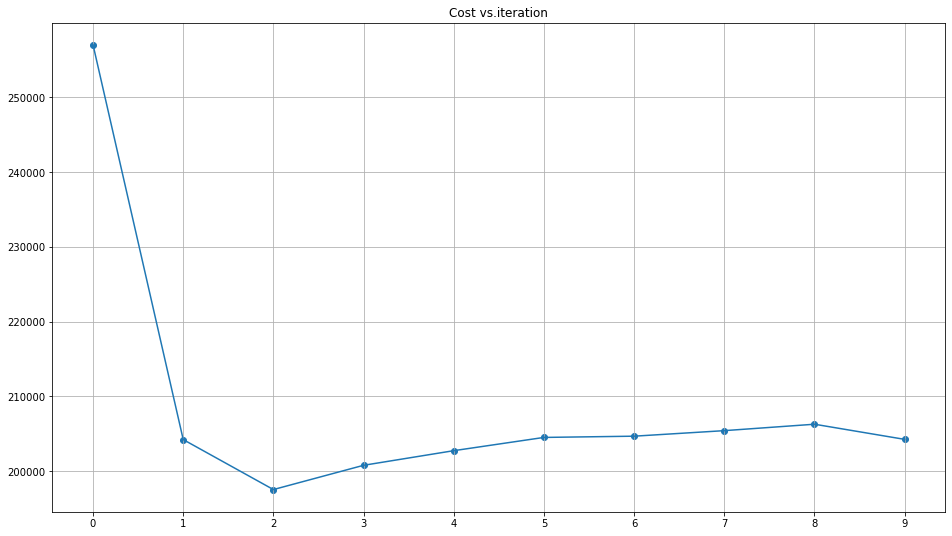

In [39]:
import matplotlib.pyplot as plt

X = np.linspace(0,9,10, dtype=int)
plt.figure(figsize=(16,9))
plt.plot(X, cost_2)
plt.scatter(X, cost_2)
plt.xticks(X)
plt.grid()
plt.title("Cost vs.iteration")
plt.show()

We can see after a few iterations, the cost drops from nearly 26,000 to around 20,000 and then oscillates around 20,5000. 